In [6]:
from rich.pretty import pprint
from typing import List, Dict, Any, Optional

## Playbook: What is Softmax and Derivatives

WIKIPEDIA

---

The softmax function takes as input a vector $z$ of $K$ real numbers, and
normalizes it into a probability distribution consisting of $K$ probabilities
proportional to the exponentials of the input numbers. That is, prior to
applying softmax, some vector components could be negative, or greater than one;
and might not sum to 1 ; but after applying softmax, each component will be in
the interval $(0,1)$, and the components will add up to 1 , so that they can be
interpreted as probabilities. Furthermore, the larger input components will
correspond to larger probabilities.

For a vector $z$ of $K$ real numbers, the standard (unit) softmax function
$\sigma: \mathbb{R}^K \mapsto(0,1)^K$, where $K \geq 1$, is defined by the
formula

$$
\sigma(\mathbf{z})_i=\frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}} \text { for } i=1, \ldots, K \text { and } \mathbf{z}=\left(z_1, \ldots, z_K\right) \in \mathbb{R}^K
$$

In words, the softmax applies the standard exponential function to each element
$z_i$ of the input vector $\mathbf{z}$ and normalizes these values by dividing
by the sum of all these exponentials. The normalization ensures that the sum of
the components of the output vector $\sigma(\mathbf{z})$ is 1 . The term
"softmax" derives from the amplifying effects of the exponential on any maxima
in the input vector. For example, the standard softmax of $(1,2,8)$ is
approximately $(0.001,0.002,0.997)$, which amounts to assigning almost all of
the total unit weight in the result to the position of the vector's maximal
element (of 8 ).

In general, instead of $e$ a different base $\mathrm{b}>0$ can be used. If
$0<\mathrm{b}<1$, smaller input components will result in larger output
probabilities, and decreasing the value of $b$ will create probability
distributions that are more concentrated around the positions of the smallest
input values. Conversely, as above, if $b>1$ larger input components will result
in larger output probabilities, and increasing the value of $b$ will create
probability distributions that are more concentrated around the positions of the
largest input values. Writing $b=e^\beta$ or $b=e^{-\beta[\mathrm{a}]}$ (for
real $\left.\beta\right)^{[\mathrm{b}]}$ yields the expressions:[c]

$$
\sigma(\mathbf{z})_i=\frac{e^{\beta z_i}}{\sum_{j=1}^K e^{\beta z_j}} \text { or } \sigma(\mathbf{z})_i=\frac{e^{-\beta z_i}}{\sum_{j=1}^K e^{-\beta z_j}} \text { for } i=1, \ldots, K
$$

The reciprocal of $\beta$ is sometimes referred to as the temperature,
$T=1 / \beta$, with $b=e^{1 / T}$. A higher temperature results in a more
uniform output distribution (i.e. with higher entropy, and "more random"), while
a lower temperature results in a sharper output distribution, with one value
dominating.

In some fields, the base is fixed, corresponding to a fixed scale,
${ }^{[\mathrm{d}]}$ while in others the parameter $\beta$ is varied.

---

In [12]:
from torch import nn
import torch
import torch.nn.functional as F

class Softmax:
    """
    Softmax activation function.
    """

    def __call__(self, z: torch.Tensor) -> torch.Tensor:
        """
        Compute the softmax function for a given input.
        """
        numerator = torch.exp(z)
        denominator = torch.sum(numerator, dim=1, keepdim=True)
        g = numerator / denominator
        return g

    def gradient(self, z: torch.Tensor) -> torch.Tensor:
        """
        Compute the derivative of the softmax function with respect to its input.
        """
        g = self.__call__(z)
        g = g.unsqueeze(-1)  # add an extra dimension
        eye = torch.eye(g.shape[1], device=z.device)[None, :]  # identity matrix
        dg_dz = g * (eye - g)
        return dg_dz.sum(dim=1)


# Create a sample input tensor
z = torch.randn(5, 10)  # Batch size of 5, 10 features



# Compare the results
print("PyTorch Softmax Output:", pytorch_softmax_outputs)


PyTorch Softmax Output: tensor([[0.0393, 0.1047, 0.0203, 0.2252, 0.1916, 0.0316, 0.2273, 0.0504, 0.0689,
         0.0407],
        [0.0243, 0.1802, 0.0876, 0.0895, 0.0414, 0.2126, 0.0688, 0.1057, 0.0289,
         0.1609],
        [0.0810, 0.0504, 0.5742, 0.0125, 0.0262, 0.0354, 0.0215, 0.0781, 0.0460,
         0.0747],
        [0.0301, 0.0559, 0.1491, 0.0595, 0.0328, 0.0501, 0.0416, 0.0215, 0.5511,
         0.0084],
        [0.0897, 0.0261, 0.4708, 0.0324, 0.0238, 0.1313, 0.0585, 0.0703, 0.0391,
         0.0581]])


In [ ]:
z = torch.randn((2, 5), requires_grad=True)
pytorch_softmax = nn.Softmax(dim=1)
pytorch_softmax_outputs = pytorch_softmax(z)


In [13]:
# Create a sample input tensor

# Use PyTorch's softmax and calculate gradients with respect to z
output_torch = F.softmax(z, dim=1)
loss_torch = output_torch.log().mean()  # Example loss for gradient calculation
loss_torch.backward()

# Gradients obtained via PyTorch
gradients_torch = z.grad.data

# Reset gradients in z for custom gradient computation
z.grad = None

# Compute softmax using custom function and calculate custom gradients
softmax = Softmax()
output_custom = softmax(z)
# For custom gradient calculation, we need an illustrative "loss" since gradients are usually
# calculated in the context of some scalar output. Here, we mimic a simple operation as a stand-in for loss.
loss_custom = output_custom.log().mean()
loss_custom.backward()

# Assuming custom gradient computation inside the backward method of a custom autograd function,
# here we manually compute it for comparison, which isn't directly applicable as is.
# gradients_custom = softmax.gradient(z)  # This line was proposed, but doesn't fit directly into the autograd framework as is.

# Print both gradients for comparison
print("Gradients via PyTorch's autograd:")
print(gradients_torch)
print("\nManual gradient computation currently doesn't integrate directly with autograd; needs adjustment.")
# Print the manually computed gradients for educational purposes, if applicable
# print("\nCustom computed gradients (for illustration, not directly comparable):")
# print(gradients_custom)

Gradients via PyTorch's autograd:
tensor([[-0.0172,  0.0806,  0.0072, -0.0803,  0.0096],
        [ 0.0730,  0.0435, -0.0768, -0.0686,  0.0288]])

Manual gradient computation currently doesn't integrate directly with autograd; needs adjustment.


In [10]:
# get gradients of nn.Softmax

z.requires_grad = True
z.retain_grad()
pytorch_softmax_outputs = pytorch_softmax(z)
pytorch_softmax_outputs.sum().backward()
print("PyTorch Softmax Gradient:", z.grad)

PyTorch Softmax Gradient: tensor([[-4.3086e-08, -5.9735e-09, -1.9813e-08, -2.2872e-08, -3.0181e-09,
         -5.1731e-08, -3.5311e-08, -1.6718e-08, -3.0283e-08, -9.6135e-09],
        [ 2.3789e-09,  8.6295e-09,  1.4517e-09,  1.9518e-08,  5.1734e-09,
          1.1618e-09,  1.5833e-08,  3.6878e-08,  1.0539e-08,  1.7647e-08],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]])


In [7]:
# Compute the softmax using the custom implementation and PyTorch's implementation
my_softmax = Softmax()
my_softmax_outputs = Softmax()(z)

print("Custom Softmax Output:", my_softmax_outputs)
print("Are the outputs close?", torch.allclose(my_softmax_outputs, pytorch_softmax_outputs))

Custom Softmax Output: tensor([[0.1807, 0.0251, 0.0831, 0.0959, 0.0127, 0.2170, 0.1481, 0.0701, 0.1270,
         0.0403],
        [0.0200, 0.0724, 0.0122, 0.1637, 0.0434, 0.0097, 0.1328, 0.3094, 0.0884,
         0.1480],
        [0.2308, 0.1091, 0.0899, 0.0602, 0.1257, 0.0426, 0.0202, 0.0306, 0.1937,
         0.0972],
        [0.0800, 0.0191, 0.0798, 0.0291, 0.0149, 0.0273, 0.2551, 0.0710, 0.0156,
         0.4081],
        [0.0312, 0.1400, 0.0057, 0.0685, 0.0484, 0.1182, 0.1219, 0.1737, 0.0918,
         0.2006]], grad_fn=<DivBackward0>)
Are the outputs close? True


In [8]:
my_softmax.gradient(z)

tensor([[ 0.0395, -0.1162, -0.0581, -0.0453, -0.1286,  0.0757,  0.0069, -0.0711,
         -0.0142, -0.1009],
        [-0.1577, -0.1052, -0.1655, -0.0139, -0.1342, -0.1679, -0.0448,  0.1317,
         -0.0892, -0.0296],
        [ 0.0880, -0.0337, -0.0529, -0.0826, -0.0171, -0.1002, -0.1225, -0.1121,
          0.0509, -0.0456],
        [-0.1719, -0.2328, -0.1720, -0.2228, -0.2369, -0.2246,  0.0033, -0.1809,
         -0.2363,  0.1562],
        [-0.1041,  0.0046, -0.1296, -0.0668, -0.0869, -0.0171, -0.0134,  0.0384,
         -0.0435,  0.0653]], grad_fn=<SumBackward1>)

## Sampling Generation

### Order Preservation in Softmax

The softmax function, defined as

$$\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j} e^{z_j}}$$

converts a vector of real-valued logits $[z_1, z_2, \ldots, z_n]$ into a
probability distribution $[p_1, p_2, \ldots, p_n]$, where each $p_i$ represents
the probability of the $i$th class. The key properties of softmax include:

-   **Order Preservation**: The softmax function preserves the order of logits.
    If a logit $z_a$ is greater than $z_b$ before applying softmax, the
    resulting probability $p_a$ will also be greater than $p_b$. This means that
    the relative ranking of logits is maintained in the probability
    distribution.
-   **Normalization**: The output probabilities sum up to 1, making it a valid
    probability distribution.

### Sharpness of Softmax Distribution

When introducing temperature $T$ into the softmax function:

$$\text{softmax}_T(z_i) = \frac{e^{z_i / T}}{\sum_{j} e^{z_j / T}}$$

the temperature modifies the "sharpness" of the probability distribution without
altering the order of the probabilities:

-   **At high temperatures** ($T > 1$), the distribution becomes more uniform,
    but if $z_a > z_b$, then $\text{softmax}_T(z_a) > \text{softmax}_T(z_b)$
    still holds. The probabilities become closer to each other, making the
    choice more "random" or "equally likely" among options, but the ranking
    remains the same.

-   **At low temperatures** ($T < 1$), the distribution becomes sharper, with a
    more pronounced difference between the higher and lower probabilities,
    amplifying the differences in likelihood as determined by the logits. The
    probability of the largest logit increases towards 1, while others decrease
    towards 0. Yet, the order of logits is preserved—higher logits translate to
    higher probabilities.

### Multinomial

In multinomial (or probabilistic) sampling, the model samples from the entire
probability distribution obtained after applying softmax:

At higher temperatures, the probability distribution becomes more uniform,
increasing the likelihood of sampling less probable tokens, thereby introducing
more randomness or diversity into the selection process. At lower temperatures,
the distribution becomes sharper, concentrating most of the probability mass on
a few high-probability tokens. This makes the selection less random and more
predictable, closely aligning with the greedy selection outcome but still
allowing for some variability.

KEY is to understand multinomial in the sampling.

### Greedy vs Probabilistic sampling

If your model employs a greedy strategy for selecting tokens (e.g., always
choosing the token with the highest probability), then adjusting the temperature
won't change the selected token. This approach is common in tasks where
precision is critical, and the aim is to reduce randomness to a minimum, such as
in certain classification tasks or when generating text where maximum coherence
is desired.

In [10]:
import torch
from typing import List
from rich.pretty import pprint

In [3]:
def demonstrate_multinomial_sampling_effect(logits: torch.Tensor, temperatures: List[float], epsilon: float = 1e-8):
    """
    Demonstrates the effect of temperature on multinomial sampling from the softmax distribution.

    Args:
        logits (torch.Tensor): The input logits.
        temperatures (list): A list of temperatures to apply.
        num_samples (int): The number of samples to draw from the distribution.

    Returns:
        dict: A dictionary mapping each temperature to its corresponding sampled outcomes.
    """
    softmax_results = {}
    sampling_results = {}
    for temperature in temperatures:
        scaled_logits = logits / (temperature + epsilon)  # Scale logits by temperature
        probs = torch.softmax(scaled_logits, dim=-1)  # Apply softmax to scaled logits
        samples = torch.multinomial(probs, num_samples=1, replacement=False)
        softmax_results[temperature] = probs.numpy()
        sampling_results[temperature] = samples.numpy()
    return softmax_results, sampling_results

1 - preserve order show it in code
2 - sample more times to show effect - distribution count for each 

In [16]:
# Example logits
logits = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0, 6.0])

# Temperatures to explore
temperatures = [0.1, 1.0, 10.0]

# Generate samples under different temperatures
softmax_distributions, sampling_distributions = demonstrate_multinomial_sampling_effect(logits, temperatures)

pprint(softmax_distributions)
pprint(sampling_distributions)

{
│   0.1: array([1.9286696e-22, 4.2481610e-18, 9.3572157e-14, 2.0610600e-09,
│      4.5397868e-05, 9.9995458e-01], dtype=float32),
│   1.0: array([0.00426978, 0.01160646, 0.03154963, 0.08576079, 0.233122  ,
│      0.6336913 ], dtype=float32),
│   10.0: array([0.12792668, 0.14138085, 0.15624999, 0.17268294, 0.19084416,
│      0.21091543], dtype=float32)
}

{0.1: array([5]), 1.0: array([5]), 10.0: array([4])}

In [18]:
logits

tensor([1., 2., 3., 4., 5., 6.])

Here's how the softmax distribution changes with different temperatures for the
given logits `[1.0, 2.0, 3.0]`:

-   **Temperature = 0.1**: The softmax probabilities are approximately
    `[2.06e-09, 4.54e-05, 0.9999]`. At this low temperature, the distribution
    becomes extremely "sharp," where the highest logit (3.0) dominates, and its
    probability is almost 1. This demonstrates the effect of low temperatures in
    making the softmax output more deterministic, favoring the highest logit
    significantly over the others.

-   **Temperature = 1.0** (no scaling): The softmax probabilities are
    `[0.09, 0.24, 0.67]`. This is the standard softmax distribution without any
    temperature scaling. The highest logit still has the highest probability,
    but the distribution is less skewed than at lower temperatures, allowing for
    some level of variability in sampling.

-   **Temperature = 10.0**: The softmax probabilities are `[0.30, 0.33, 0.37]`.
    At this high temperature, the distribution becomes much "softer," and the
    probabilities are closer to each other, making the outcome more uniform.
    This indicates increased randomness in sampling, as the differences between
    the logits are dampened, making it less predictable which token will be
    sampled.

### Conclusion

-   **Low temperatures** sharpen the softmax distribution, increasing the
    probability of the highest logit significantly and making the model's output
    more predictable.

-   **High temperatures** soften the softmax distribution, equalizing the
    probabilities and introducing more randomness into the model's output.

This demonstrates the practical effect of temperature on the behavior of softmax
and, by extension, on the sampling strategy used in generative models.

To cater to a mathematical audience, let's delve deeper into the formal
definition of multinomial sampling and its connection to temperature-scaled
softmax distributions in the context of sequence generation models.

### Multinomial Distribution

The multinomial distribution is a generalization of the binomial distribution.
It models the probabilities of observing counts among multiple categories and is
parametrized by probabilities $\pi_1, \pi_2, \ldots, \pi_n$ corresponding to $n$
outcomes. These probabilities must satisfy two conditions:

1. $0 \leq \pi_i \leq 1$ for all $i$,
2. $\sum\_{i=1}^{n} \pi_i = 1$.

Given a single trial, the probability of outcome $i$ occurring is $\pi_i$. When
sampling from a multinomial distribution, each sample (or draw) is independent,
and the probability of observing a specific outcome follows the distribution
defined by $\pi$.

### Formalizing Multinomial Sampling

In the context of generative models, after computing the softmax distribution
over the logits (or scores) $z_i$ for each token $i$ in the vocabulary, the
softmax function at temperature $T$ is applied to obtain probabilities:

$$p*i = \frac{\exp(z_i / T)}{\sum*{j=1}^{n} \exp(z_j / T)}$$

Here, $p_i$ represents the probability of selecting token $i$ as the next token
in the sequence, forming a probability distribution
$\pi = [p_1, p_2,
\ldots, p_n]$ over the vocabulary.

Given $\pi$, multinomial sampling draws a sample $s$ where $P(s=i) = p_i$. This
process can be repeated to generate sequences of tokens.

### Impact of Temperature on Multinomial Sampling

The temperature parameter $T$ modulates the sharpness of the probability
distribution $\pi$:

-   **For $T < 1$**, the distribution becomes sharper, with a higher probability
    concentrated on the tokens with the highest logits. This makes the sampling
    process more deterministic, as the variance among the probabilities is
    increased, favoring the selection of the most likely token.

-   **For $T = 1$**, the distribution is exactly the softmax of the logits,
    representing the model's learned probabilities without modification.

-   **For $T > 1$**, the distribution becomes flatter, making less likely tokens
    more probable to be selected. This introduces more randomness into the
    sampling process, as the variance among the probabilities is decreased.

### Example in Sequence Generation

Consider generating text from a model trained on a large corpus. At each step,
the model outputs logits, which are transformed into probabilities $\pi$ using
the softmax function scaled by temperature $T$. Multinomial sampling is then
used to select the next token from these probabilities. Adjusting $T$ allows
controlling the randomness and diversity of the generated text: lower $T$ favors
more predictable text closely following the training data, while higher $T$
favors more novel and varied sequences.

This formal treatment of multinomial sampling and temperature's role offers a
nuanced understanding of how generative models like GPT navigate the trade-offs
between diversity and fidelity in sequence generation.


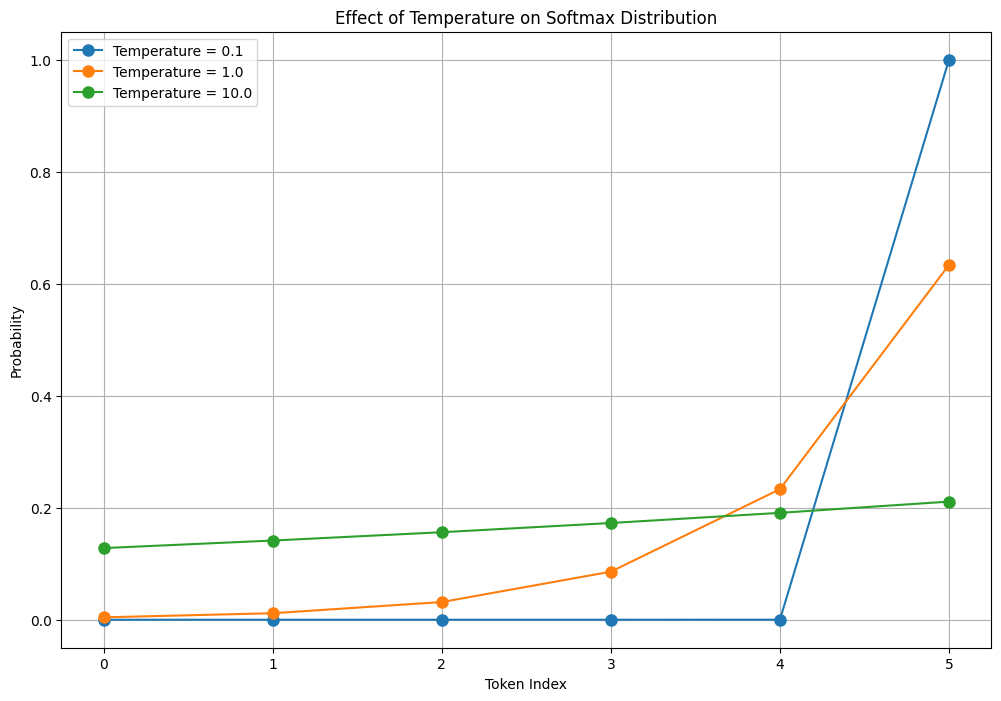

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def softmax(logits, temperature=1.0):
    """Compute softmax values for each set of logits in x."""
    scaled_logits = logits / temperature
    exp_logits = np.exp(scaled_logits - np.max(scaled_logits))  # for numerical stability
    return exp_logits / np.sum(exp_logits)

plt.figure(figsize=(12, 8))

logits = logits.numpy()

for temp in temperatures:
    probs = softmax(logits, temperature=temp)
    plt.plot(probs, label=f'Temperature = {temp}', marker='o', linestyle='-', markersize=8)

plt.title('Effect of Temperature on Softmax Distribution')
plt.xlabel('Token Index')
plt.ylabel('Probability')
plt.xticks(range(len(logits)))
plt.legend()
plt.grid(True)
plt.show()


# Why Do We Like To Use Warmup and Cosine Schedulers?

In [22]:
from __future__ import annotations

from typing import List

from torch import nn
from torch.optim import Adam, Optimizer
from torch.optim.lr_scheduler import _LRScheduler, StepLR


def get_learning_rates(optimizer: Optimizer, scheduler: _LRScheduler, steps: int) -> List[float]:
    lrs = []
    for _ in range(steps):
        lrs.append(optimizer.param_groups[0]["lr"])
        optimizer.step()  # Dummy step
        scheduler.step()
    return lrs

dummy_model = nn.Linear(1, 1)
optimizer = Adam(dummy_model.parameters(), lr=0.1)
scheduler = StepLR(optimizer, step_size=1, gamma=0.5)
lrs = get_learning_rates(optimizer, scheduler, steps=5)
print(lrs)


[0.1, 0.05, 0.025, 0.0125, 0.00625]


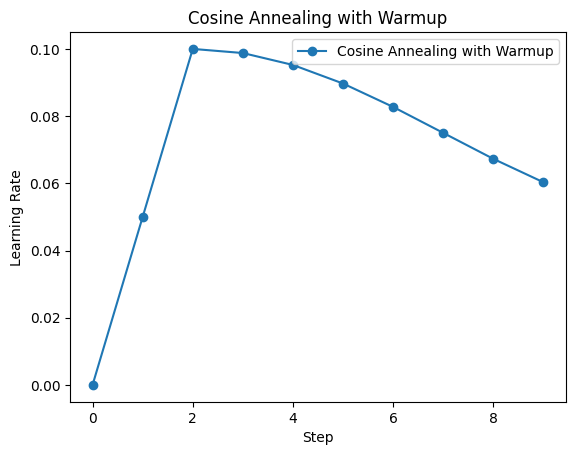

In [26]:
from __future__ import annotations

import math
from functools import partial

from torch.optim.lr_scheduler import LambdaLR
from torch.optim.optimizer import Optimizer


def _get_cosine_schedule_with_warmup_lr_lambda(
    current_step: int, *, num_warmup_steps: int, num_training_steps: int, alpha_f: float
) -> float:
    """
    Helper function for calculating the learning rate using cosine annealing
    with warmup.

    Parameters
    ----------
    current_step: int
        The current step in the training process.
    num_warmup_steps: int
        The number of steps for the warmup phase.
    num_training_steps: int
        The total number of training steps.
    alpha_f: float
        The minimum learning rate at the end of the schedule.

    Returns
    -------
    float
        The calculated learning rate.
    """

    if current_step < num_warmup_steps:
        alpha = current_step / max(1, num_warmup_steps)
    else:
        tau_w = (current_step - num_warmup_steps) / num_training_steps
        tau_w = min(1.0, tau_w)
        alpha = alpha_f + (1 - alpha_f) * (1 + math.cos(math.pi * tau_w)) / 2
    return alpha


def get_cosine_annealing_with_warmup(
    optimizer: Optimizer,
    num_warmup_steps: int,
    num_training_steps: int,
    alpha_f: float = 0.1,
    last_epoch: int = -1,
    verbose: bool = False,
) -> LambdaLR:
    """
    Create a schedule with a learning rate that decreases following the values
    of the cosine function between the initial lr set in the optimizer to 0,
    after a warmup period during which it increases linearly between 0 and the
    initial lr set in the optimizer.

    Parameters
    ----------
    optimizer: `~torch.optim.Optimizer`
        The optimizer for which to schedule the learning rate.
    num_warmup_steps: int
        The number of steps for the warmup phase.
    num_training_steps: int
        The total number of training steps.
    alpha_f: float, optional
        The minimum learning rate at the end of the schedule, by default 0.1.
    last_epoch: int, optional
        The index of the last epoch when resuming training, by default -1.
    verbose: bool, optional
        Whether to print the learning rate at every update, by default False.

    Returns
    -------
    `torch.optim.lr_scheduler.LambdaLR`
        The scheduler with the appropriate schedule.
    """

    lr_lambda = partial(
        _get_cosine_schedule_with_warmup_lr_lambda,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps,
        alpha_f=alpha_f,
    )
    return LambdaLR(optimizer, lr_lambda, last_epoch, verbose)


num_warmup_steps = 2
num_training_steps = 10
alpha_f = 0.5
initial_lr = 1e-1

dummy_model = nn.Linear(1, 1)
optimizer = Adam(dummy_model.parameters(), lr=initial_lr)
scheduler = get_cosine_annealing_with_warmup(optimizer, num_warmup_steps, num_training_steps, alpha_f)
assert isinstance(scheduler, LambdaLR)
lrs = get_learning_rates(optimizer, scheduler, steps=num_training_steps)

import matplotlib.pyplot as plt

def plot_learning_rates(lrs: List[float], title: str, marker: str = "o", ax: plt.Axes | None = None, **kwargs: Any) -> None:
    ax = ax or plt.gca()

    ax.plot(lrs, label=title, marker=marker, **kwargs)
    ax.set_title(title)
    ax.set_xlabel("Step")
    ax.set_ylabel("Learning Rate")
    ax.legend()

plot_learning_rates(lrs, "Cosine Annealing with Warmup")

In [31]:
((math.cos(0.2 * math.pi) + 1)*(0.25) + 0.5) * 3e-4


0.00028567627457812104

In [ ]:
optimizer = AdamW(model.parameters(), lr=initial_lr)

scheduler_1 = get_cosine_annealing_with_warmup(optimizer, t_warmup, t_max, alpha_f)
lrs = []
for epoch in range(t_max + 1):
    optimizer.step()
    scheduler_1.step()
    lr = optimizer.param_groups[0]["lr"]
    lrs.append(lr)

lrs

In [2]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim import AdamW
from torch import nn
model = nn.Linear(10, 2)
optimizer = AdamW(model.parameters(), lr=0.1)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0.01)
print(type(scheduler.get_lr()[0]))

<class 'float'>


/opt/homebrew/Caskroom/miniconda/base/envs/omniverse/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:809: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


In [3]:
from __future__ import annotations
import torch
import math
from typing import List

from torch.optim.optimizer import Optimizer
from torch.optim.lr_scheduler import LambdaLR
from functools import partial

def cosine_annealing_with_warmup(t: int, t_warmup: float, t_max: float, alpha_f: float) -> float:
    """Computes the learning rate multiplier using cosine annealing with warmup.

    Parameters
    ----------
    t : int
        Current training step.
    t_warmup : float
        Warmup time in training steps.
    t_max : float
        Total duration of the scheduler in training steps.
    alpha_f : float
        Learning rate multiplier to decay to.

    Returns
    -------
    alpha : float
        The learning rate multiplier at the given training step.
    """
    if t < t_warmup:
        alpha = t / t_warmup
    else:
        tau_w = (t - t_warmup) / t_max
        tau_w = min(1.0, tau_w)
        alpha = alpha_f + (1 - alpha_f) * (1 + math.cos(math.pi * tau_w)) / 2
    return alpha


- refer to hf
- refer to mosaic so to highlight a bit diff in impleentations

In [32]:
from transformers import get_cosine_schedule_with_warmup

In [53]:

initial_lr = 0.1 # eta_max
t_warmup = 2
t_max = 10
alpha_f = 0.01
steps = np.arange(1, t_max + 1)

# Learning rate values
lr_values = [
    initial_lr
    * cosine_annealing_with_warmup(t, t_warmup, t_max, alpha_f)
    for t in steps
]
lr_values

[0.05,
 0.1,
 0.09757729755661011,
 0.09054634122155991,
 0.07959536998847742,
 0.0657963412215599,
 0.0505,
 0.03520365877844011,
 0.021404630011522586,
 0.010453658778440107]

In [54]:
optimizer = AdamW(model.parameters(), lr=initial_lr)

scheduler_1 = get_cosine_annealing_with_warmup(optimizer, t_warmup, t_max, alpha_f)
lrs = []
for epoch in range(t_max + 1):
    optimizer.step()
    scheduler_1.step()
    lr = optimizer.param_groups[0]["lr"]
    lrs.append(lr)

lrs

[0.05,
 0.1,
 0.09757729755661011,
 0.09054634122155991,
 0.07959536998847742,
 0.0657963412215599,
 0.0505,
 0.03520365877844011,
 0.021404630011522586,
 0.010453658778440107,
 0.0034227024433899004]

In [46]:
scheduler_hf = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=t_warmup, num_training_steps=t_max+t_warmup, num_cycles=0.5)

lrs_hf = []
for epoch in range(t_max + 1):
    optimizer.step()
    scheduler_hf.step()
    lr = optimizer.param_groups[0]["lr"]
    lrs_hf.append(lr)

lrs_hf

[0.05,
 0.1,
 0.09797464868072488,
 0.09206267664155907,
 0.08274303669726427,
 0.07077075065009433,
 0.05711574191366427,
 0.04288425808633575,
 0.029229249349905687,
 0.017256963302735746,
 0.007937323358440935]

In [69]:
initial_lr

0.001

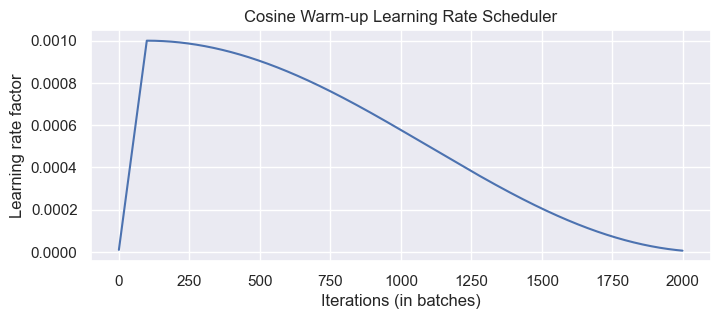

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

total_steps = 2000

initial_lr = 1e-3 # eta_max
t_warmup = 100
t_max = total_steps
alpha_f = 0
steps = np.arange(1, total_steps + 1)

p = nn.Parameter(torch.empty(4,4))
optimizer = AdamW([p], lr=initial_lr)
scheduler = get_cosine_annealing_with_warmup(optimizer, t_warmup, t_max, alpha_f)

# Plotting
epochs = list(range(total_steps))
lrs = []
for epoch in epochs:
    optimizer.step()
    scheduler.step()
    lr = optimizer.param_groups[0]["lr"]
    lrs.append(lr)


sns.set()
plt.figure(figsize=(8,3))
plt.plot(epochs, lrs)
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

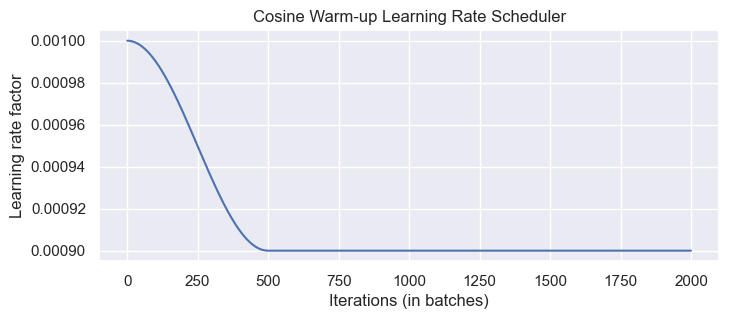

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

total_steps = 2000
initial_lr = 1e-3 # eta_max
t_warmup = 10

t_max = int(total_steps / 4) # oscillate 4 times
alpha_f = 0.9
steps = np.arange(1, total_steps + 1)

p = nn.Parameter(torch.empty(4,4))
optimizer = AdamW([p], lr=initial_lr)
scheduler = get_cosine_annealing_with_warmup(optimizer, t_warmup, t_max, alpha_f)

# Plotting
epochs = list(range(total_steps))
lrs = []
for epoch in epochs:
    optimizer.step()
    scheduler.step()
    lr = optimizer.param_groups[0]["lr"]
    lrs.append(lr)


sns.set()
plt.figure(figsize=(8,3))
plt.plot(epochs, lrs)
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()